In [2]:
from pymed import PubMed
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from pandas import option_context
import qgrid

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Pubmed query

In [95]:
search_terms = '(alcohol OR addiction OR "use disorder" OR "binge drinking") AND ("ecological momentary" OR "smartphone" OR "experience sampling" OR "mobile phone" OR "ambulatory assessment")'

In [96]:
# Login
pubmed = PubMed(tool="MyTool", email="my@email.address")

In [97]:
# Searching articles
results = pubmed.query(search_terms, max_results=5000)
articles = [r for r in results]
df = pd.DataFrame([a.toDict() for a in articles])
df = df.set_index('pubmed_id', verify_integrity=True)

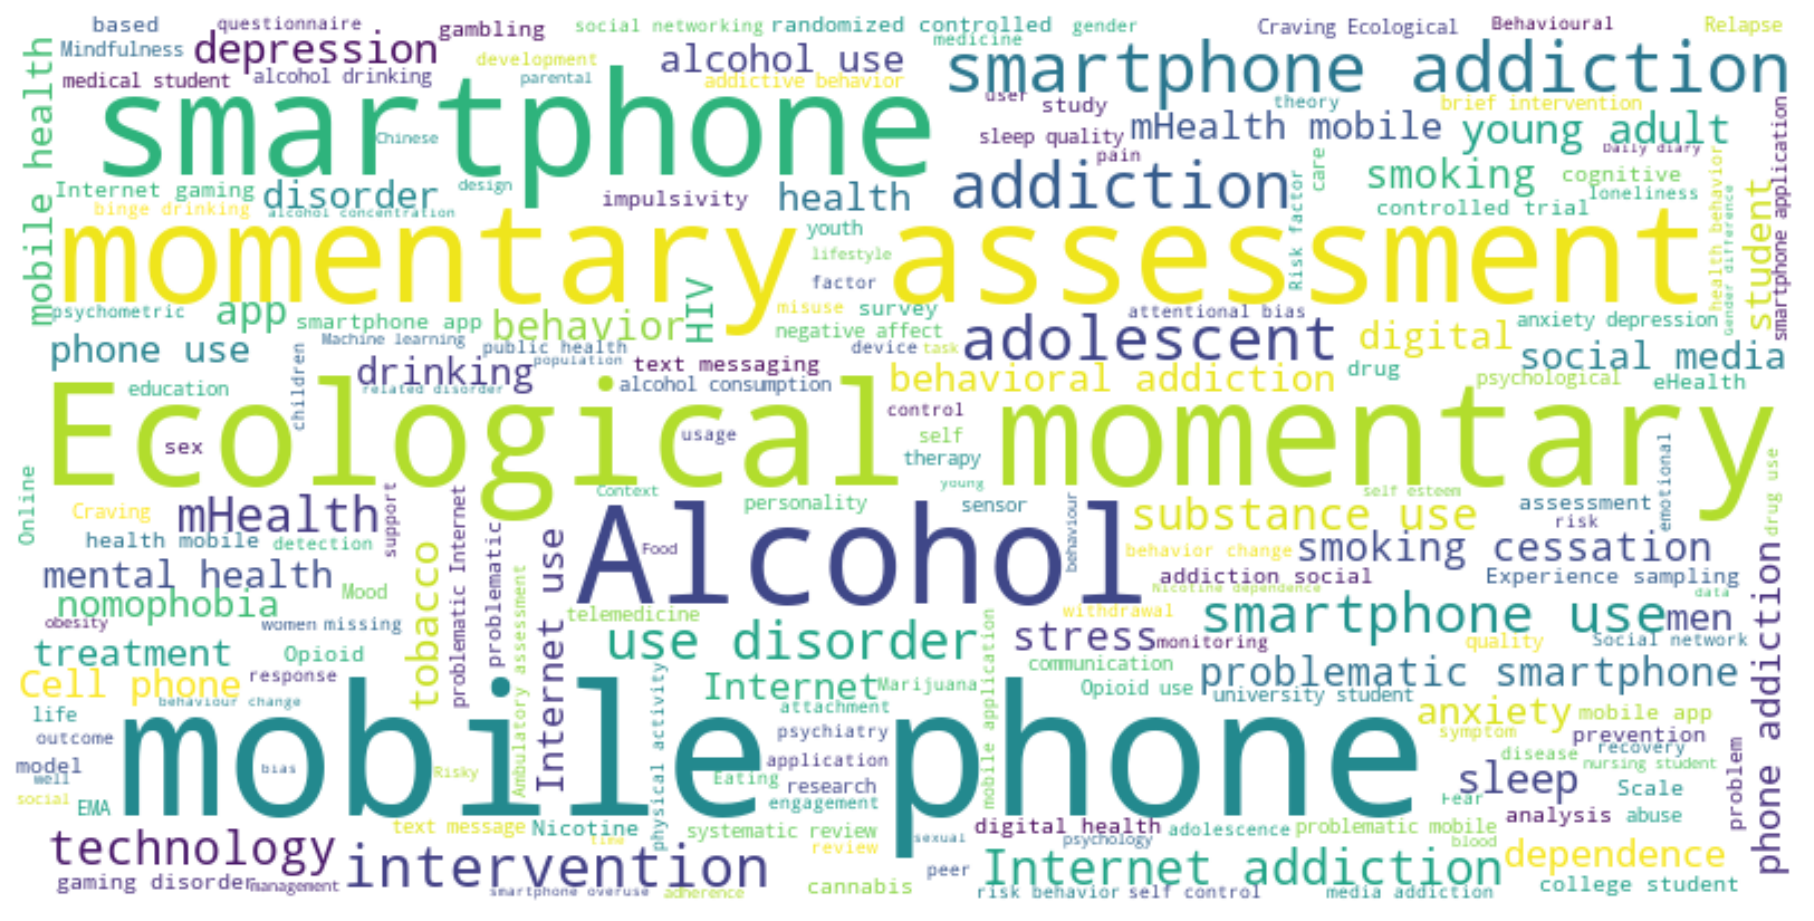

In [237]:
keywords = [keyword for l in df.keywords.values if l==l for keyword in l if keyword!=None] # This hopefully still works
plt.figure(figsize = (16,12))
wordcloud = WordCloud(background_color="white",width=800, height=400).generate(' '.join(keywords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
sns.despine()

Missed 
- "Real-Time Mobile Monitoring of Drinking Episodes in Young Adult Heavy Drinkers" https://pubmed.ncbi.nlm.nih.gov/31746774/

# Selecting based on titles
The first manual selection brings articles down to 235.

In [3]:
filtered = pd.read_pickle('reviewed.pkl')
col_opts = { 'editable': True }
col_defs = { 'pass': { 'editable': True,'maxWidth': 50 },
            'pubmed_id': { 'maxWidth': 0, 'minWidth': 0, 'width': 0 },
           'title': {'minWidth':500}}
filtered['row'] = filtered.reset_index().index
#filtered['title'] = filtered.title.apply(lambda x: x[2:])
print(len(filtered))
widget = qgrid.show_grid(filtered[['pass','title','publication_date']], column_options=col_opts, column_definitions=col_defs)
widget

636


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
filtered['pass'] = False
filtered['pass'] = widget.get_changed_df()['pass']
filtered['pass'] = filtered['pass'].astype(bool)
filtered.to_pickle('reviewed.pkl')

In [6]:
filtered.to_pickle('reviewed_backup_2015.pkl')

In [7]:
pd.read_pickle('reviewed.pkl')['pass'].sum()

235

# Categorization based on abstracts

In [139]:
filtered = pd.read_pickle('reviewed.pkl')
filtered = filtered[(filtered['pass']==True) & (filtered.abstract.isna()==False) &(len(filtered.abstract)>0)]#.reset_index()
filtered['ema'] = True
filtered['task'] = False
filtered['phys'] = False
filtered['abstract_checked'] = False
filtered['note'] = ""
filtered.to_pickle('reviewed_abstract.pkl')


In [181]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from functools import partial
filtered = pd.read_pickle('reviewed_abstract.pkl')


class Counter:
   def __init__(self, initial=111):
      self.value = initial
counter = Counter()

next_button = widgets.Button(description="Next")
last_button = widgets.Button(description="Last")
button_ui = widgets.HBox([last_button, next_button])


ema = widgets.Checkbox(description="Ema", value= False)
task = widgets.Checkbox(description="Task", value = False)
phys = widgets.Checkbox(description="Physiology", value = False)

note = widgets.Textarea(
    value='',
    placeholder='Add notes here',
    description='String:',
    disabled=False
)

boxes = [ema, task, phys, note]

check_ui = widgets.HBox([ema, task, phys, note], layout=Layout(width='80%'))

title = widgets.HTML(value="Test", layout=Layout(width='80%'))

abstract = widgets.HTML(value="Test", layout=Layout(width='60%'))

output = widgets.Output()

display(check_ui)
display(button_ui, output)
display(title)
display(abstract)

abstract.value = filtered.loc[filtered.index[counter.value], 'abstract']
t = filtered.loc[filtered.index[counter.value], 'title']
if filtered.loc[filtered.index[counter.value], 'abstract_checked']:
    t += " <font color='green'>(checked)</font>"
title.value = f"<b>%s</b>"%t
ema.value = bool(filtered.loc[filtered.index[counter.value], 'ema'])
task.value = bool(filtered.loc[filtered.index[counter.value], 'task'])
phys.value = bool(filtered.loc[filtered.index[counter.value], 'phys'])

def on_last_button_clicked(counter, filtered, abstract, boxes, b):
    filtered.loc[filtered.index[counter.value], 'ema'] = ema.value
    filtered.loc[filtered.index[counter.value], 'task'] = task.value
    filtered.loc[filtered.index[counter.value], 'phys'] = phys.value
    filtered.loc[filtered.index[counter.value], 'note'] = note.value


    counter.value -= 1    
    a = filtered.loc[filtered.index[counter.value], 'abstract']
    abstract.value = a.replace('Participants','<b>Participants</b>').replace('participants','<b>participants</b>')
    t = filtered.loc[filtered.index[counter.value], 'title']
    if filtered.loc[filtered.index[counter.value], 'abstract_checked']:
        t += " <font color='green'>(checked)</font>"
    title.value = f"<b>%s</b>"%t

    ema.value = bool(filtered.loc[filtered.index[counter.value], 'ema'])
    task.value = bool(filtered.loc[filtered.index[counter.value], 'task'])
    phys.value = bool(filtered.loc[filtered.index[counter.value], 'phys'])
    note.value = filtered.loc[filtered.index[counter.value], 'note']

    #with output:
    #    print("Last button clicked."+ str(counter.value))

def on_next_button_clicked(counter, filtered, abstract, boxes, b):
    filtered.loc[filtered.index[counter.value], 'ema'] = ema.value
    filtered.loc[filtered.index[counter.value], 'task'] = task.value
    filtered.loc[filtered.index[counter.value], 'phys'] = phys.value
    filtered.loc[filtered.index[counter.value], 'note'] = note.value
    filtered.loc[filtered.index[counter.value], 'abstract_checked'] = True

    counter.value += 1
    a = filtered.loc[filtered.index[counter.value], 'abstract']
    abstract.value = a.replace('Participants','<b>Participants</b>').replace('participants','<b>participants</b>')
    t = filtered.loc[filtered.index[counter.value], 'title']
    if filtered.loc[filtered.index[counter.value], 'abstract_checked']:
        t += " <font color='green'>(checked)</font>"
    title.value = f"<b>%s</b>"%t
    ema.value = bool(filtered.loc[filtered.index[counter.value], 'ema'])
    task.value = bool(filtered.loc[filtered.index[counter.value], 'task'])
    phys.value = bool(filtered.loc[filtered.index[counter.value], 'phys'])
    note.value = filtered.loc[filtered.index[counter.value], 'note']
    
    
    #with output:
    #    print("Next button clicked."+ str(counter.value))
    
def check_box_clicked(counter, filtered, name, b):
    print(name)


next_button.on_click(partial(on_next_button_clicked, counter, filtered, abstract, boxes))
last_button.on_click(partial(on_last_button_clicked, counter, filtered, abstract, boxes))


Output()

HTML(value='Test', layout=Layout(width='80%'))

HTML(value='Test', layout=Layout(width='60%'))

IndexError: index 235 is out of bounds for axis 0 with size 235

In [203]:
# Don't forget to double check papers that do not have abstracts
# e.g. "An ecological momentary assessment of mood, coping and alcohol use among emerging adults in psychiatric treatment"
# Remove articles that have remove in notes
# Physiology should be physiology/sensors
filtered.to_pickle('reviewed_abstract.pkl')

In [204]:
filtered.reset_index().iloc[200:250][['title','ema','task','phys','note','abstract_checked']]

,title,ema,task,phys,note,abstract_checked
200,Ecological momentary assessment of working me...,True,True,False,"potentially a working memory task, I will have...",True
201,Higher stimulus control is associated with le...,True,False,False,self-reported stimulus control,True
202,A quantitative evaluation of alcohol withdraw...,True,False,True,interesting but for more severe drinkers,True
203,Smartphone-based colorimetric analysis for de...,True,False,True,potentially very cool sensor to measure saliva...,True
204,Consumption and foraging behaviors for common...,True,False,False,,True
205,Development and psychometric properties of th...,True,False,False,,True
206,Social stress in early adolescents' daily liv...,True,False,False,,True
207,Momentary affect and risky behavior correlate...,True,False,False,,True
208,Ecological Momentary Assessment of the Associ...,True,False,False,,True
209,Examining the relationship between daily chan...,True,False,False,,True


In [186]:
len(filtered)

235

# Download

In [188]:
test = filtered[filtered['pass']==True].iloc[-10:]

In [189]:
test['link'] = test.doi.apply(get_scihub_link)

In [185]:
import re
import urllib
from pathlib import Path
import requests

def get_scihub_link(doi):
    # Getting html
    if '\n' in doi:
        doi = doi.split('\n')[0] # This is not ideal as the first doi might not be the best
    fp = urllib.request.urlopen("https://sci-hub.se/%s#"%doi)
    mybytes = fp.read()
    mystr = mybytes.decode("utf8")
    fp.close()
    if "article not found" in mystr or len(mystr)==0:
        return None
    # Getting download link
    first = '<div id="article">\n        <iframe src = "'
    second = '#view=FitH'
    s = 'asdf=5;iwantthis123jasd'
    result = re.search('%s(.*)%s'%(first,second), mystr)
    link = result.group(1)
    return link

def download(link, path):
    filename = Path(path)
    url = link #?download=true
    response = requests.get(url)
    filename.write_bytes(response.content)

### Abstract cloud

In [257]:
import re

keywords = list(set([keyword.lower().strip() for l in filtered[filtered['pass']].keywords.values if l==l for keyword in l if keyword!=None])) # This hopefully still works

replace_terms = {
    "drinking":"consuming alcohol",
    "ecological momentary assessment": "ema"
    
}

keywords = list(set(keywords) - set(['research','study','alcohol use', 'alcohol consumption']))
for index, line in filtered[filtered['pass']].reset_index().iterrows():
    sentences = line['abstract'].split('. ')
    for sentence in sentences:
        for k, v in replace_terms.items():
            sentence = sentence.replace(k,v)
        sentence_ref = "%s (%s, %s)."%(sentence, line.authors[0]['lastname'], str(line.publication_date)[:4])
        for keyword in keywords:
            if keyword in sentence and "[[%s]]"%keyword not in sentence:
                sentence_ref = sentence_ref + "[[%s]]"%keyword
        #print(sentence_ref)
        with open("../notes/%s.md"%re.sub('[^\w\-_\. ]', '_', sentence[:200]),"w") as f:    
            f.write(sentence_ref)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


In [260]:
import re

keywords = list(set(keywords) - set(['research','study','alcohol use', 'alcohol consumption']))
for index, line in filtered[filtered['pass']].reset_index().iterrows():
    body = line.abstract + ' '.join(["[[%s]]"%k for k in line.keywords])
    
    title = "%s (%s, %s)."%(line.title, line.authors[0]['lastname'], str(line.publication_date)[:4])
    
    with open("../keywords/%s.md"%re.sub('[^\w\-_\. ]', '_', title[:200]),"w") as f:    
            f.write(body)

        